Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/00.4-REVIEW-introduction_to_sklearn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# REVIEW: Introduction to Scikit-Learn

Scikit-learn is a popular general-purpose machine learning library for Python programmers. It is "an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities."

The `scikit-learn` library is very well-designed [This paper](https://arxiv.org/abs/1309.0238) outlines the main design principles that went into its creation. In a nutshell, they are:

**Consistency**
All objects share a consistent and simple interface that distinguishes between three different kinds of objects:

* **Estimators**: Any object that can estimate some parameters based on a dataset is called an estimator. All estimators implement a `fit()` method. This is where the estimation (learning) itself is performed.
* **Transformers**: These are estimators that can transform datasets. The transformation is performed by the `transform()` method. All transformers also have a convenient method called `fit_transform()`, which is equivalent to calling `fit()` and then `transform()`.

* **Predictors**: Some estimators, like those of supervised learning, are capable of making predictions and therefore are called predictors. All predictors implement two methods: a `predict()` and a `score()`. While the `predict()` method returns the predicted values, the `score()` method returns a measure of the quality of these predictions (for example accuracy for classification problems, and coefficient of determination $R^2$ for regression problems).

**Inspection**
All hyperparameters are accessible as public instance variables, and all learned (estimated from data) parameters are accessible as public instance variables with an underscore suffix.

**Nonproliferation of classes**
Datasets are represented as NumPy arrays or SciPy sparse matrices. Classes are used for estimators, transformers, and predictors.

**Composition**
New estimators can be created from existing building blocks. This done using pipelines and feature unions.

**Sensible defaults**
Finally, `scikit-learn` provides reasonable default values for most parameters, making it easier to use.

As you use the classes and functions of `scikit-learn`, make sure to always reference [their documentation pages](https://scikit-learn.org/stable/) for explanations and code examples.

Scikit-learn depends on Numpy and works well with Pandas. Let's import `scikit-learn`, inspect its version.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
sklearn.__version__

'1.6.0'

Scikit-learn consists of multiple packages/modules. One such package is called `datasets`. It contains a few popular sample datasets as well as various functions for creating sample datasets. Let's use this package to load the Iris dataset.

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

where `X` is a 4-dimensional input array with 150 examples (also known as samples or rows), and `y` is the target (output or ground truth) column with three classes (encoded as 0, 1, and 2) representing following Iris flower types:

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

## Splitting the data into training and testing

To train supervised machine learning models to recognize these flower types, we need to split the dataset into two portions: training and testing. We can use the `train_test_split` from the `model_selection` package to do that. This function will automatically shuffle the data.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

where X_? represents the input portion of the ? dataset and y_? the output portion. We'll set the test dataset aside for now. Let's print the first few examples of the training dataset and make sure that it's shuffled.

In [5]:
X_train[:5, :], y_train[:5]

(array([[4.8, 3.4, 1.9, 0.2],
        [6.1, 2.8, 4. , 1.3],
        [6.1, 3. , 4.9, 1.8],
        [5.4, 3. , 4.5, 1.5],
        [7.3, 2.9, 6.3, 1.8]]),
 array([0, 1, 2, 1, 2]))

## Using estimators

Scikit learn comes with all kinds of supervised machine learning models. They are called **estimators** and can be broken into two groups: classifiers and regressors. A classifier (or a regressor) is typically implemented using a class. The constructor of that class is where hyper-parameters are set. It also consists of multiple other methods. Two methods in particular are implemented by almost all of these classifiers and regressors:

* `fit(X, y)` which takes the training dataset and trains the model with it.
* `predict(X)` which makes predictions for the unseen data it is given.

Having these two methods give these estimators a consistent interface that makes it easy to use all sort of estimators once you know how to use one. As an example, we'll train a Nearest Neighbor (NN) classifier to predict the flower type given the above Iris data.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Let's plot the training confusion matrix and print its accuracy.

Accuracy: 1.0


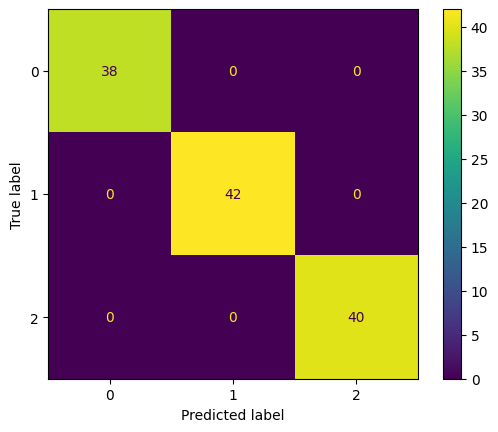

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

print(f"Accuracy: {accuracy_score(y_train, nn.predict(X_train))}")
ConfusionMatrixDisplay.from_estimator(nn, X_train, y_train)

1.0 accuracy score (or 100% accuracy) wow! Perhaps, however, we are overfitting.

## K-Fold cross-validation
Let's convert the above classifier to a K-Nearest Neighbors model. If you call the function:

In [8]:
nn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

You will get the list of hyper-parameters the model has. One of these parameters is `n_neighbors` which is the `K` in K-NearestNeighbor. Since we don't really know the best value for this parameter, we use K-fold cross-validation to find that out. Sciket-learn's `model_selection` package provides multiple functions for implementing cross-validation. Once such function is simply called `cross_validate`.

Here is an example using this function to find out the best value for the `n_neighbors` parameter. It's critical to always remember that in Scikit-learn, cross-validation functions don't use errors or loss functions for scoring. Instead they use utility functions where larger is better. As you see below, we are using the accuracy for scoring instead of the misclassification error.

In [9]:
from sklearn.model_selection import cross_validate
ks, scores =[], []
for k in range(1,16):
    nn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(nn, X_train, y_train, scoring='accuracy', cv=10)

    np.mean(cv_results['test_score'])
    ks.append(k)
    scores.append(np.mean(cv_results['test_score']))

Here is a function to plot the cross-validation curve. In the code above, the `cv=10` parameter means 10-fold cross-validation.

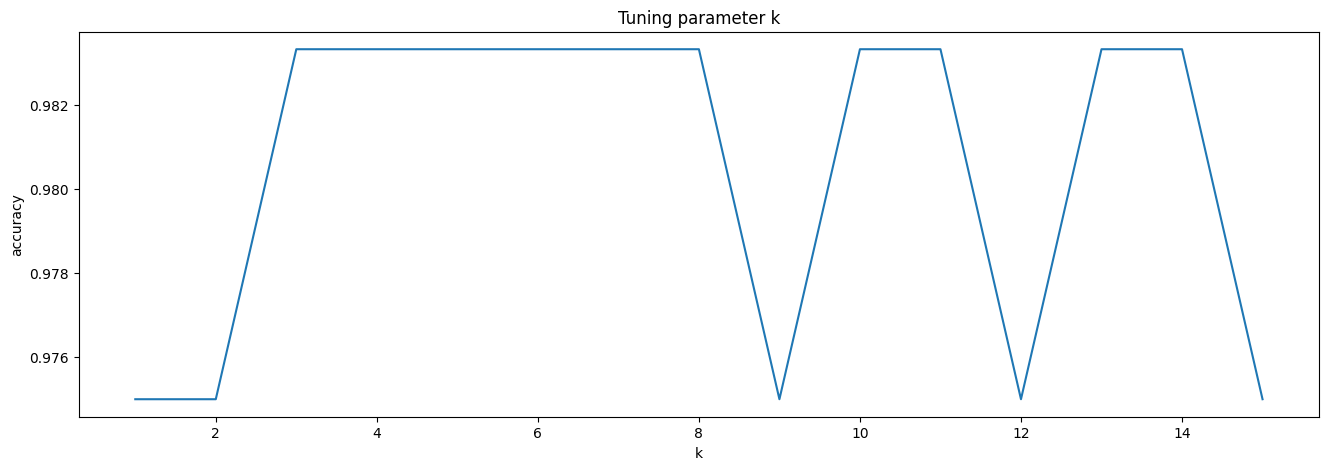

In [10]:
def plot_cv_curve(x, y, xlabel, ylabel, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(16,5))
    ax.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

plot_cv_curve(ks, scores, "k", "accuracy", "Tuning parameter k")

Here is the best value for the `n_neighbors` parameter. The `+ 1` is because `np.argmax` returns a 0-based index and our parameter values start at 1.

In [11]:
np.argmax(scores) + 1

3

We now train a KNN model with this best `n_neighbors` value:

In [12]:
knn = KNeighborsClassifier(n_neighbors=np.argmax(scores) + 1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

And we can finally test this model using our set-aside test dataset. Let's plot the testing confusion matrix and print its accuracy.

Accuracy: 0.9


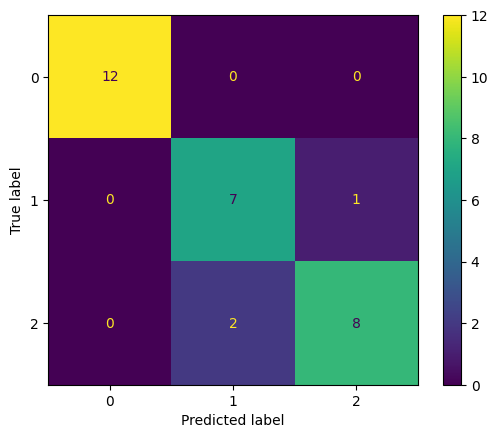

In [13]:
print(f"Accuracy: {accuracy_score(y_test, knn.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)

## Using and plotting decision trees
To show how easy it is to train multiple models in Scikit-learn using the same interface, let's use a decision tree to recognize the Iris flower types using the same above dataset split.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 0,
 'splitter': 'best'}

As you can see, decision trees have many hyper-parameters. Let's tune one them: `max_depth`. We'll use another cross-validation function (called `cross_val_score`) for that.

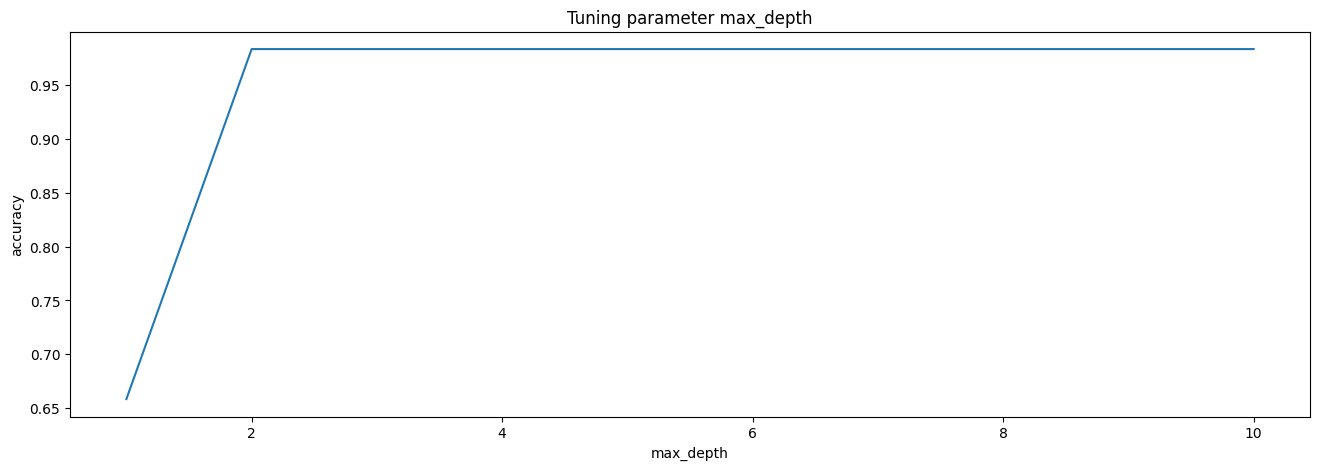

In [15]:
from sklearn.model_selection import cross_val_score

ds, scores =[], []
for d in range(1,11):
    dt = DecisionTreeClassifier(random_state=0, max_depth=d)
    ds.append(d)
    scores.append(np.mean(cross_val_score(dt, X_train, y_train, scoring='accuracy', cv=10)))

plot_cv_curve(ds, scores, "max_depth", "accuracy", "Tuning parameter max_depth")

and here is the best `max-depth` value.

In [16]:
np.argmax(scores) + 1

2

Let train and test a decision tree using this best value.

Accuracy: 0.9


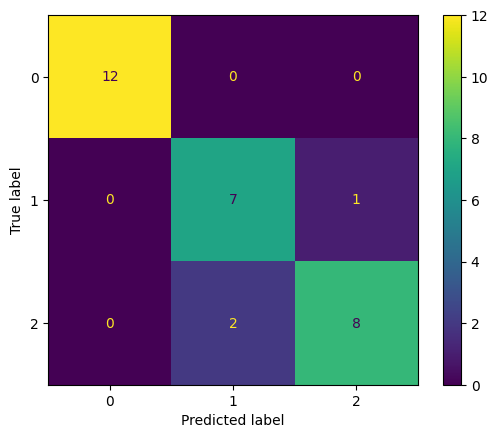

In [17]:
dt = DecisionTreeClassifier(random_state=0, max_depth=np.argmax(scores) + 1)
dt.fit(X_train, y_train)

print(f"Accuracy: {accuracy_score(y_test, knn.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)

And we can even plot the actual tree of this model:

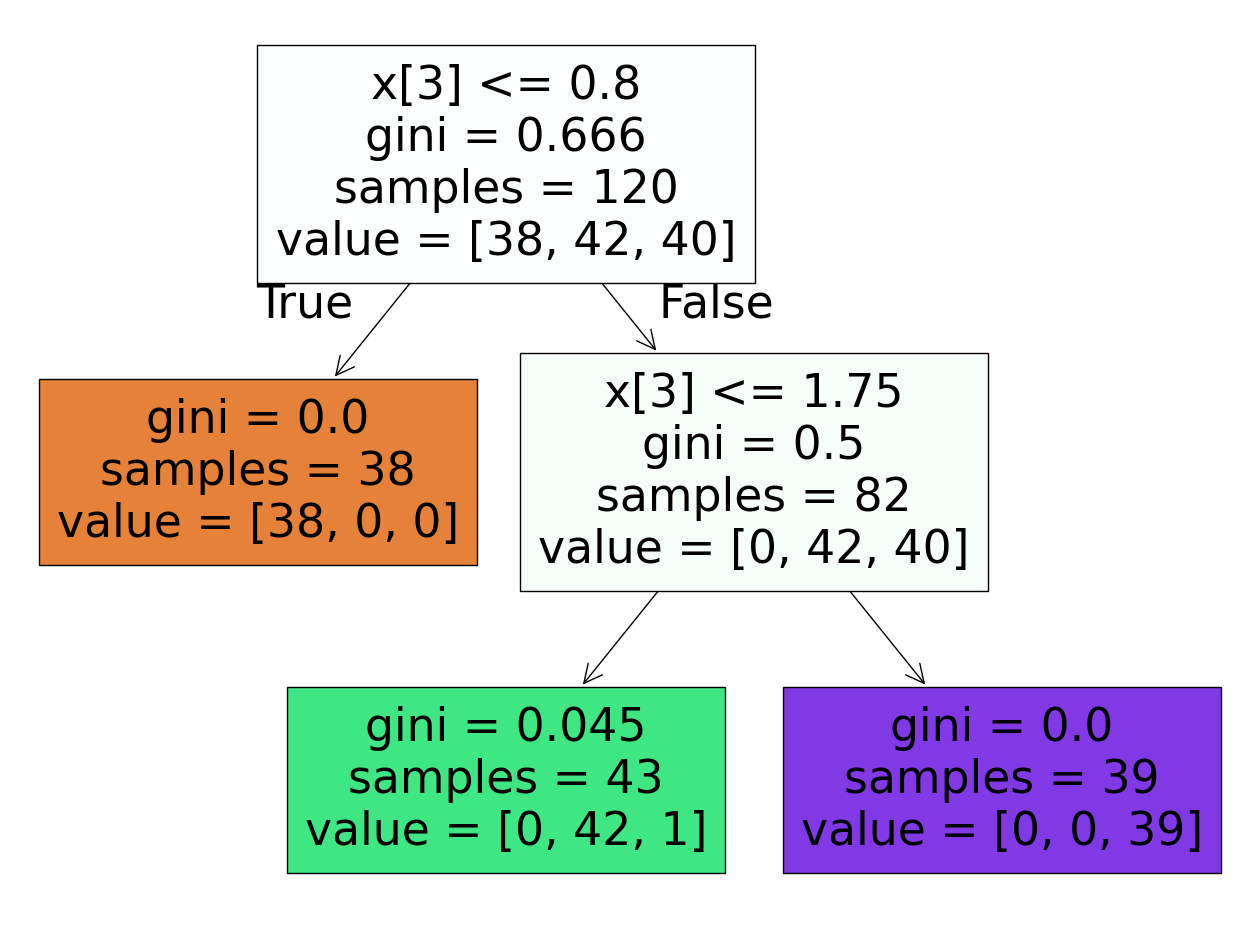

In [18]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(16,12))
ax = fig.subplots(1, 1)
plot_tree(dt, ax=ax, filled=True);

## Reading data in
Data could also be read from external sources such as files or URLs. Here is an example using the [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine).

In [19]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df.columns = [
    'y', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]

As you see, the first column is the output column. Let's move it to the end.

In [20]:
df = df[[*df.columns[1:], df.columns[0]]]
df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,y
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


Let's split it into training and testing portions. This time we are passing Pandas' dataframes to the `train_test_split()` function.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:, -1], test_size=0.2)

This dataset has multiple input features as well as a categorical output. Let's train and print a simple decision tree model.

Here is an example of tuning more than one hyper parameter: `max_features` and `max_depth`. We'll use cross-validation for both and plot the curves side by side.

Best max_depth: 3, Best max_features: 4


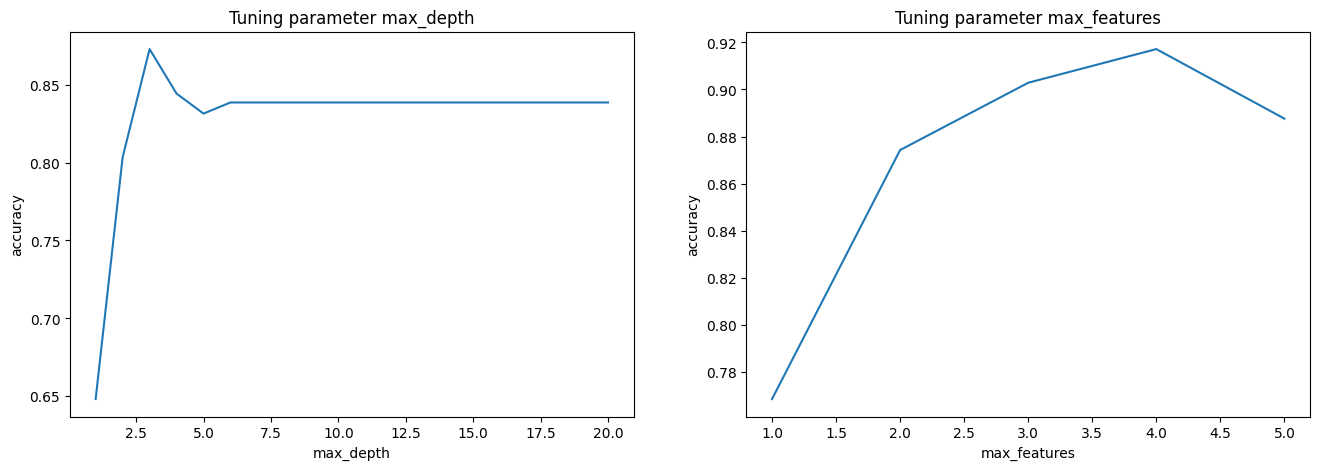

In [22]:
ds, dscores =[], []
for d in range(1,21):
    dt = DecisionTreeClassifier(random_state=0, max_depth=d)
    ds.append(d)
    dscores.append(np.mean(cross_val_score(dt, X_train, y_train, scoring='accuracy', cv=10)))

fs, fscores =[], []
for f in range(1,6):
    dt = DecisionTreeClassifier(random_state=0, max_features=f)
    fs.append(f)
    fscores.append(np.mean(cross_val_score(dt, X_train, y_train, scoring='accuracy', cv=10)))


fig, axes = plt.subplots(1, 2, figsize=(16,5))

plot_cv_curve(ds, dscores, "max_depth", "accuracy", "Tuning parameter max_depth", ax=axes[0])
plot_cv_curve(fs, fscores, "max_features", "accuracy", "Tuning parameter max_features", ax=axes[1])

print(f"Best max_depth: {np.argmax(dscores) + 1}, Best max_features: {np.argmax(fscores) + 1}")

We now train a decision tree model using these best values.

In [23]:
dt = DecisionTreeClassifier(random_state=0, max_depth=np.argmax(dscores) + 1, max_features=np.argmax(fscores) + 1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features=4, random_state=0)

Accuracy: 0.8888888888888888


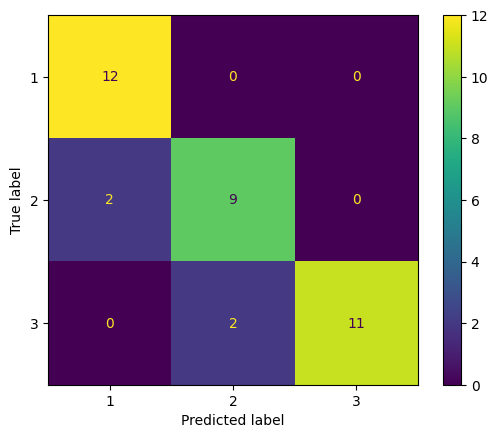

In [24]:
print(f"Accuracy: {accuracy_score(y_test, dt.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

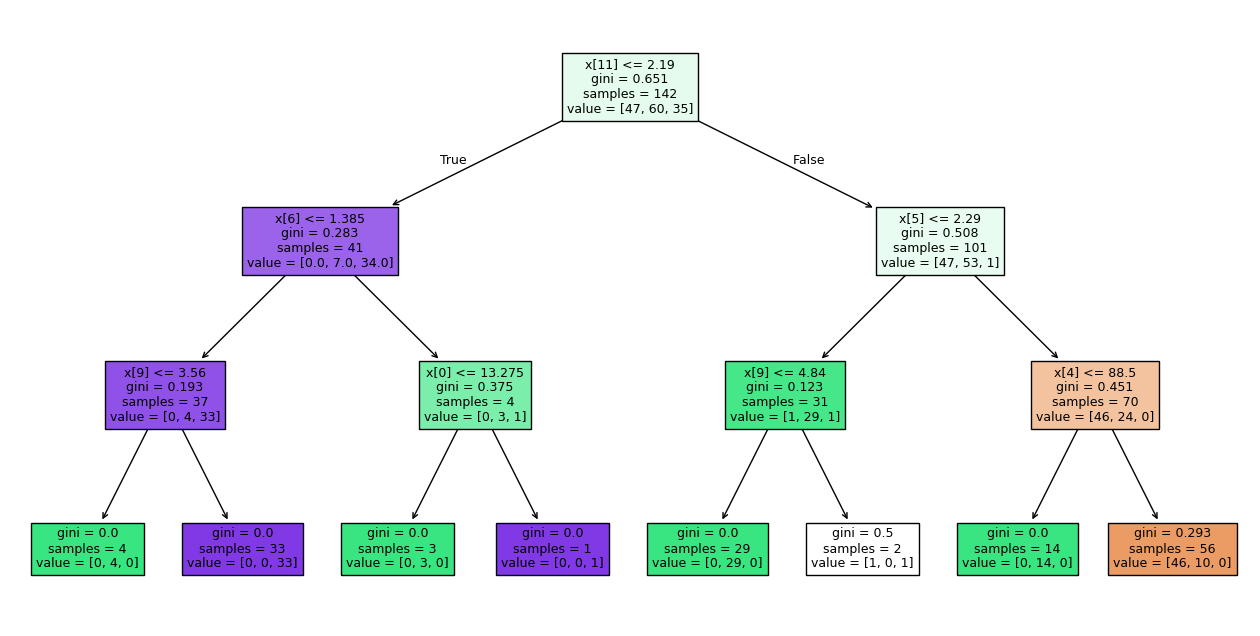

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
plot_tree(dt, ax=ax, filled=True);

## Parameter tuning using Grid search

We can use cross-validation grid search to tune multiple parameters at once. This performs an exhaustive search over all the given parameter values.

In [26]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': range(1, 16), 'max_features': range(1, 6)}
dt = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(dt, parameters)
gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(1, 16),
                         'max_features': range(1, 6)})

We can now get best parameter values and their score.

In [27]:
gs.best_score_, gs.best_params_

(0.9362068965517241, {'max_depth': 4, 'max_features': 4})

Notice that these values might be different from the earlier ones we got. This is because grid search does not apply parameter tuning one parameter at a time. Instead, it tries all possible combinations of all parameters. Let's train a tree model with these new best values:

Accuracy: 0.9444444444444444


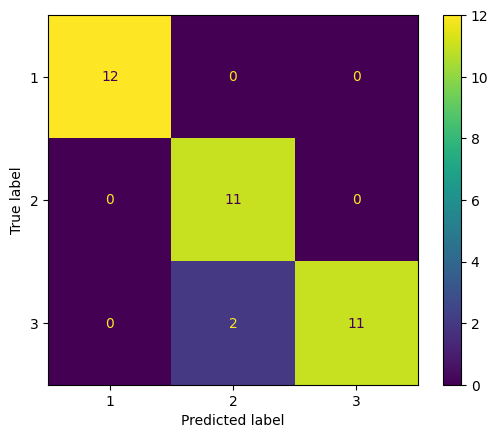

In [28]:
dt = DecisionTreeClassifier(random_state=0,
                            max_depth=gs.best_params_['max_depth'],
                            max_features=gs.best_params_['max_features'])
dt.fit(X_train, y_train)

print(f"Accuracy: {accuracy_score(y_test, dt.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

And here is that tree:

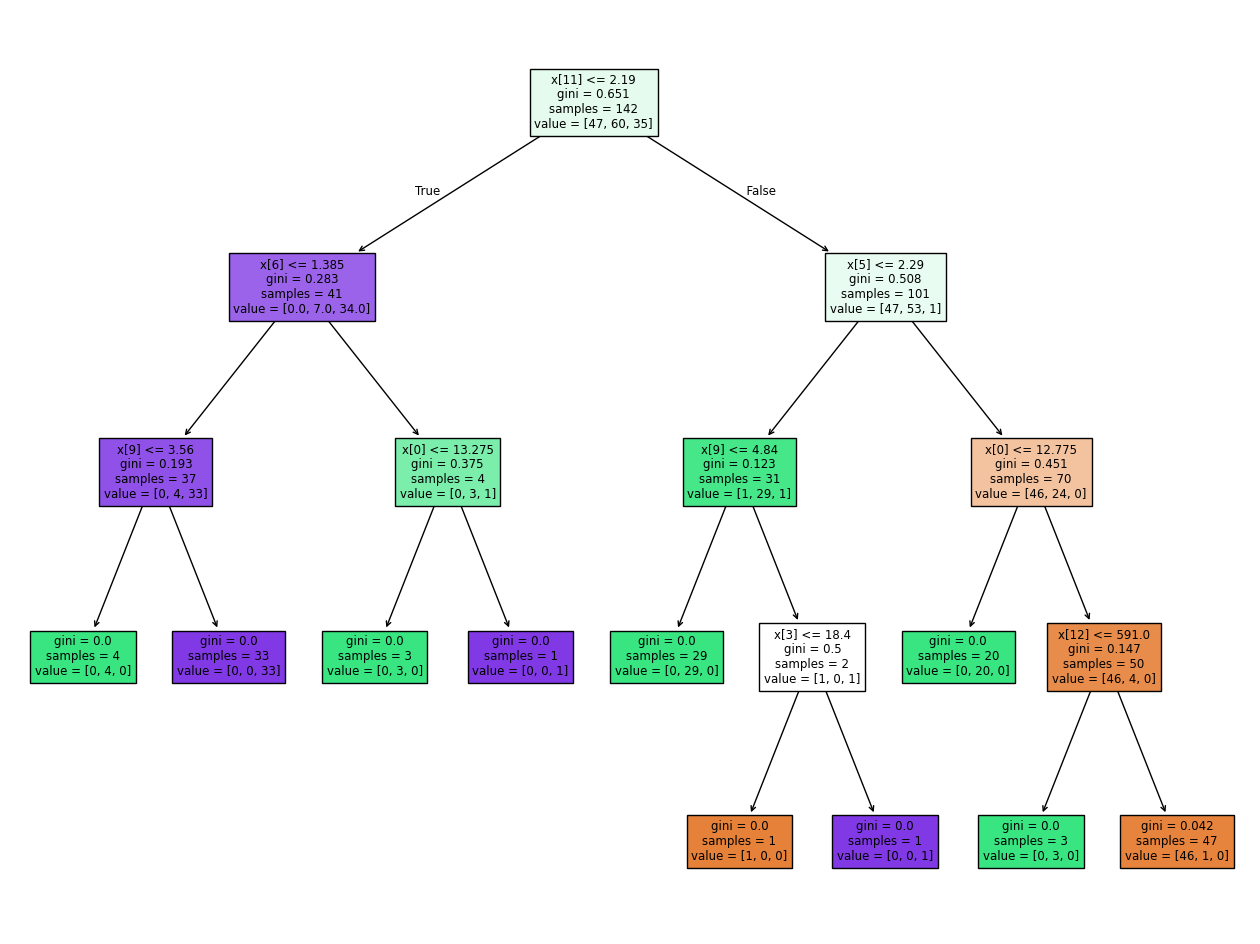

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16,12))
plot_tree(dt, ax=ax, filled=True);

## Feature importance in random forests
Another model we can try is random forest. We use is the same way as the other classifiers we have tried. Let's also use grid search to tune three of its hyper parameters: `n_estimators`, `max_depth`, and `max_features`. THIS WILL TAKE A WHILE.

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

parameters = {
    'n_estimators': range(20,81,10),
    'max_depth': range(1, 11),
    'max_features': range(1, 6)
}

gs = GridSearchCV(rf, parameters)
gs.fit(X_train, y_train)

gs.best_score_, gs.best_params_

(0.9859605911330049, {'max_depth': 2, 'max_features': 1, 'n_estimators': 80})

Wow! That took a while to run. This is the main problem with `GridSearchCV`. The total combinations that result from all the parameters and their values can be too large and require a lot of time to go through. When this happens, a better alternative to `GridSearchCV` is `RandomizedSearchCV`. Unlike `GridSearchCV`, `RandomizedSearchCV` does not try all parameter values. Instead a fixed number of parameter settings is sampled from the specified distributions.

Let's redo the above hyper parameter using `RandomizedSearchCV`.

In [31]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(rf, parameters)
rs.fit(X_train, y_train)


rs.best_score_, rs.best_params_

(0.9859605911330049, {'n_estimators': 40, 'max_features': 1, 'max_depth': 5})

Let's train a random forest model using these best values.

Accuracy: 0.9722222222222222


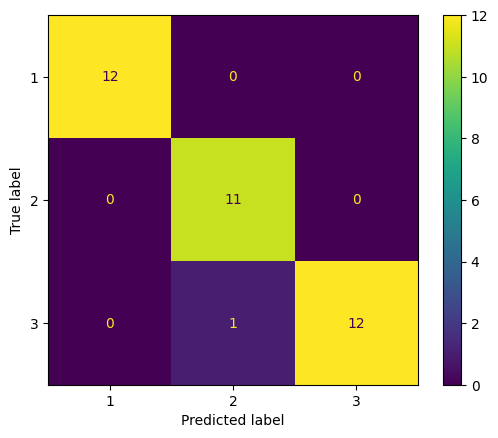

In [32]:
rf = RandomForestClassifier(random_state=0,
                            max_depth=gs.best_params_['max_depth'],
                            max_features=rs.best_params_['max_features'],
                            n_estimators=rs.best_params_['n_estimators'])
rf.fit(X_train, y_train)

print(f"Accuracy: {accuracy_score(y_test, rf.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

One great feature of Scikit-learn's implementation of random forests is the ability to calculate how important a feature is. According to Scikit-learn documentation, "Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it  Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. Let's see which feature(s) of the above random forest is more important".

Here is how to print and plot these importance values.

0.06 Alcohol
0.06 Malic acid
0.03 Ash
0.05 Alcalinity of ash
0.08 Magnesium
0.09 Total phenols
0.08 Flavanoids
0.04 Nonflavanoid phenols
0.08 Proanthocyanins
0.1 Color intensity
0.12 Hue
0.12 OD280/OD315 of diluted wines
0.1 Proline


Text(0.5, 1.0, 'Feature importance')

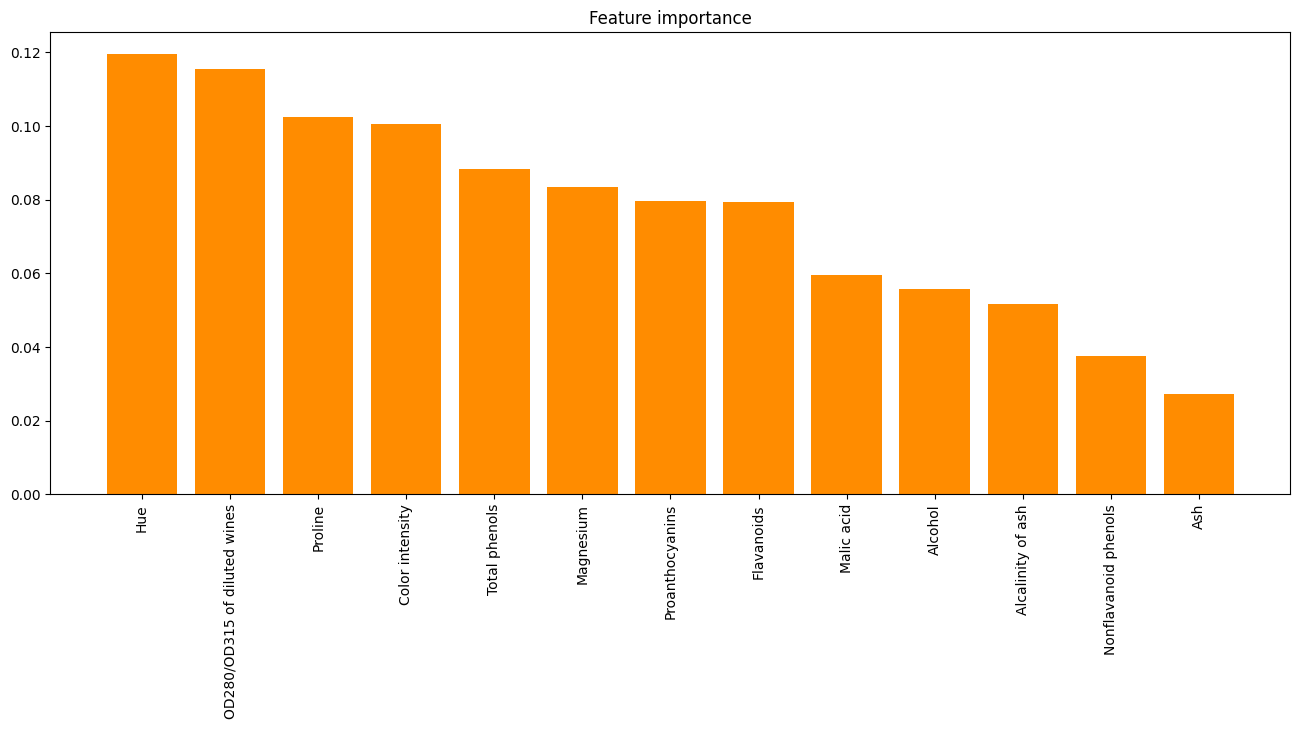

In [33]:
importances = rf.feature_importances_
for score, name in zip(importances, df.columns[:-1]):
    print(round(score, 2), name)

indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.bar(range(X_train.shape[1]), importances[indices], align='center', color="darkorange")
plt.xticks(range(X_train.shape[1]), df.columns[:-1][indices], rotation=90)
plt.title('Feature importance')

## Preprocessing data
Next we use MLP which requires all the features to be scaled. To do that, we use either `StandardScaler` (for standardization) and `MinMaxScaler` (for normalization). Both of these scalers are implemented by Scikit-learn's `preprocessing` package. They both provide a `fit_transform` method to do the actual scaling. Let's try both of them side by side.

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X, y = df.iloc[:,:-1], df.iloc[:, -1]

std_scaler, mmx_scaler = StandardScaler(), MinMaxScaler()
X_standarized, X_normalized = std_scaler.fit_transform(X), mmx_scaler.fit_transform(X)

Let's print the original input data along with the scaled ones:

In [35]:
X.to_numpy()[:3,], X_standarized[:3,], X_normalized[:3,]

(array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
         3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, 1.000e+02, 2.650e+00,
         2.760e+00, 2.600e-01, 1.280e+00, 4.380e+00, 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00,
         3.240e+00, 3.000e-01, 2.810e+00, 5.680e+00, 1.030e+00, 3.170e+00,
         1.185e+03]]),
 array([[ 1.51861254, -0.5622498 ,  0.23205254, -1.16959318,  1.91390522,
          0.80899739,  1.03481896, -0.65956311,  1.22488398,  0.25171685,
          0.36217728,  1.84791957,  1.01300893],
        [ 0.24628963, -0.49941338, -0.82799632, -2.49084714,  0.01814502,
          0.56864766,  0.73362894, -0.82071924, -0.54472099, -0.29332133,
          0.40605066,  1.1134493 ,  0.96524152],
        [ 0.19687903,  0.02123125,  1.10933436, -0.2687382 ,  0.08835836,
          0.80899

We are now ready to split the data and train an MLP model. First we use the standardized data. Let's split the data.

In [36]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X_standarized, y, test_size=0.2)

And train the MLP model.

Accuracy: 0.9722222222222222


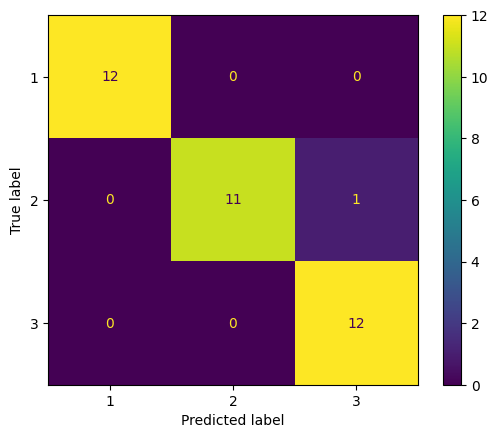

In [37]:
mlp = MLPClassifier(random_state=1, max_iter=700).fit(X_train, y_train)

print(f"Accuracy: {accuracy_score(y_test, mlp.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

Hand here is the same using the normalized data.

Accuracy: 0.9722222222222222


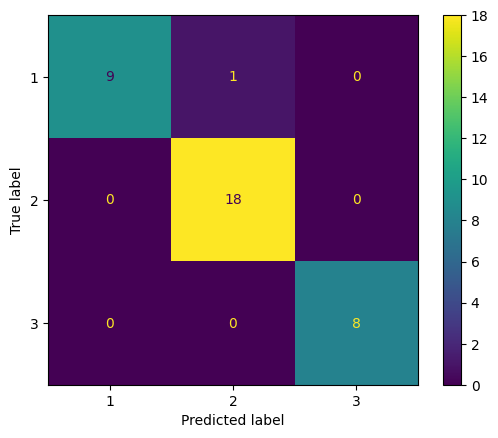

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2)
mlp = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)

print(f"Accuracy: {accuracy_score(y_test, mlp.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

## Compressing data (dimensionality reduction)
Trying to visualize the data above is impossible since it 6 dimension. So we need to use dimensionality reduction techniques to transform it to two dimensions. As an example, we will use PCA.

In [39]:
from sklearn.decomposition import PCA

X, y = X_normalized, y

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

We can then print the PCA's explained variance ratio:

In [40]:
print(f"Explained variance ratio (first two components): {pca.explained_variance_ratio_}")

Explained variance ratio (first two components): [0.40749485 0.18970352]


Let's also plot the first two principal components of the transformed data:

Text(0.5, 1.0, 'PCA-transformed data')

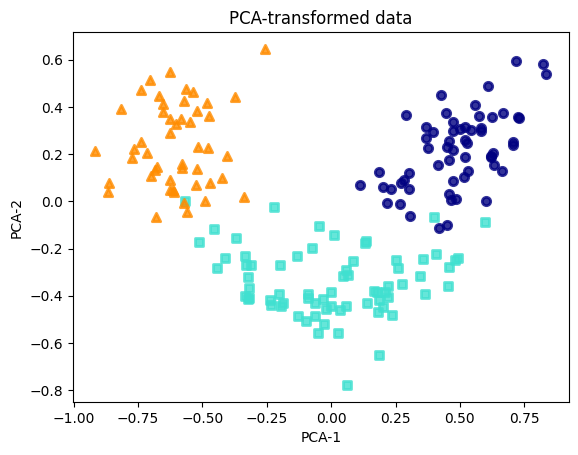

In [41]:
colors = ["navy", "turquoise", "darkorange"]
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_pca[y == l, 0], X_pca[y == l, 1],
                lw=2, c=c, alpha=0.8, label=f"Class {l}", marker=m)

plt.xlabel(f"PCA-1")
plt.ylabel(f"PCA-2")
plt.title(f"PCA-transformed data")


And in the case of PCA, we can even evaluate the contributions of the original features to these principal components. Such contributions are called **loadings**. They are calculated by the following formula:

$$loading_f = eigenvector_f \times \sqrt{eigenvalues}$$

In [42]:
eigen_vals, eigen_vecs = np.linalg.eig(np.cov(X_train.T))
loadings = eigen_vecs * np.sqrt(eigen_vals)

To show the contribution of each of the original features to the first principal component:

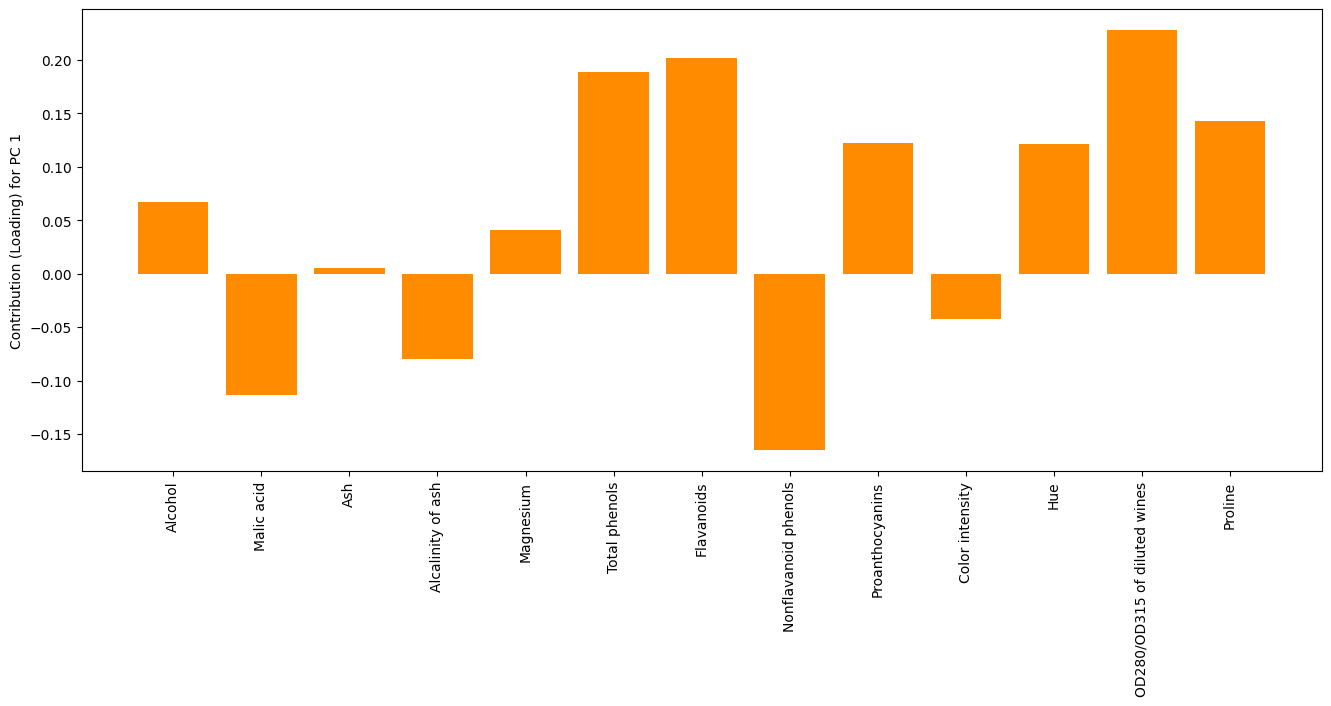

In [43]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.bar(range(X_train.shape[1]), loadings[:, 0], align='center', color="darkorange")
ax.set_ylabel('Contribution (Loading) for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df.columns[:-1], rotation=90);

## Using pipelines

Most machine learning problems require passing the data through a series of transformation steps (such as scaling, on-hot encoding, etc) before it is used to train an estimator. Instead of doing these steps manually one at a time, Scikit learn allows us to streamline them using pipelines. A pipeline is a set of transforming tasks followed by an estimator.

As an example, we'll download the [Wisconsin Breast Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+\(diagnostic\)). This data set has 30 numeric input features (columns 2 to 31) and an output column (#1) with two classes: B for benign and M for malignant.

In [44]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
    header=None)
X, y = df.iloc[:, 2:], df.iloc[:, 1]

We also need to change the output classes to numeric values. We can use `LabelEncoder` to do that.

In [45]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

Here is what the encoded classes or labels are and what the transformed output column looks like:

In [46]:
encoder.classes_, y

(array(['B', 'M'], dtype=object),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
    

Next we need to scale the input features, use PCA to compress it to two dimensions, before we train a logistic regression model. We will use a pipeline for this instead of doing these steps individually.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(StandardScaler(),
                         PCA(n_components=2),
                         LogisticRegression())

We now split the dataset:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

and train the model:

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

Let's also test it:

Accuracy: 0.9473684210526315


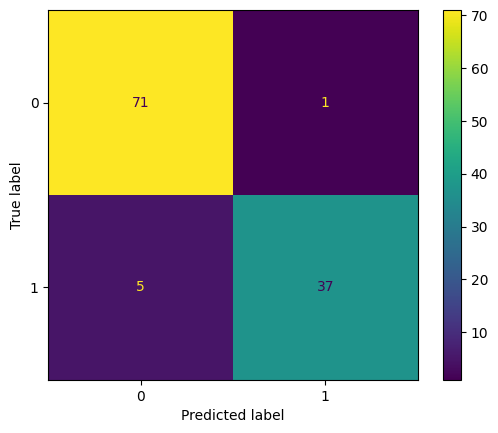

In [50]:
print(f"Accuracy: {accuracy_score(y_test, pipeline.predict(X_test))}")
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

We can also display other metrics, as well, using the `classification_report` function.

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipeline.predict(X_test), target_names=encoder.classes_))

              precision    recall  f1-score   support

           B       0.93      0.99      0.96        72
           M       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



Finally, let's display the ROC curve and calculate the AUC (Area Under the Curve), which is an additional performance metric. Note the use of the `predict_proba` function instead of the `predict` function. Also note that the `y_score` argument passed to `roc_curve` is the slice of the predict_proba output corresponding to the positive `M` class (`[:, 1]`).

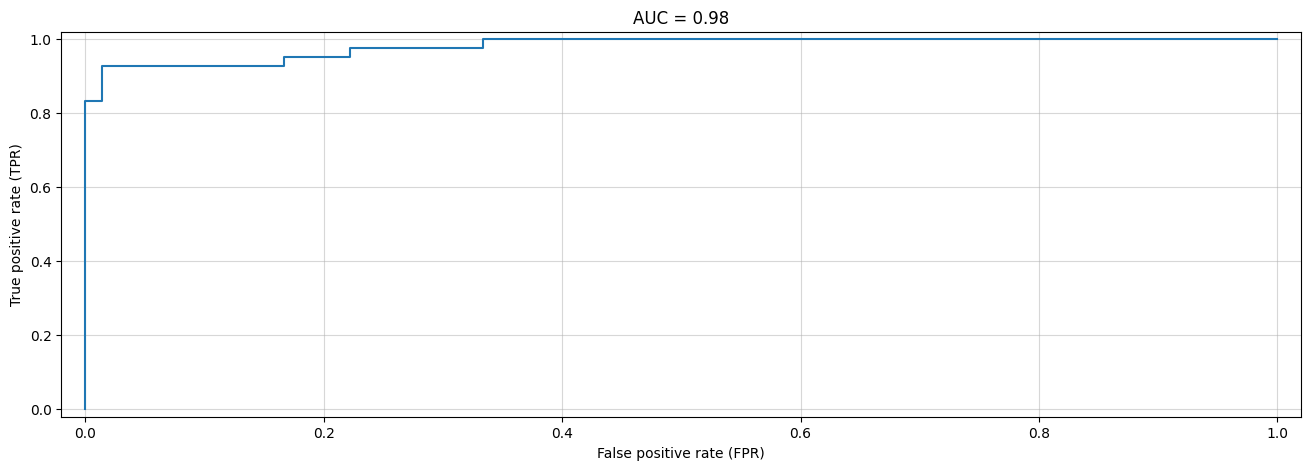

In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(16, 5))
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title(f"AUC = {roc_auc:.2f}")
plt.show()

## Clustering

Scikit-learn support clustering algorithms such as GMM and K-Means. Here is an example of using K-Means using the digits dataset. Let's load the dataset first.

In [53]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
(N, M), n_digits = X.shape, len(np.unique(y))

print(f"N: { N }, M: { M}, # of digits: {n_digits}")

N: 1797, M: 64, # of digits: 10


Using K-Means requires two main things:
* A way to initialize the centers. For that we can use stochastic method by providing the values `k-means++` or `random` to the `init=` parameter. You can look up those methods in the documentation pages to see exactly what they do. Or we can use PCA for initialization, which we will do in this example.
* A value for `K` (using the `n_clusters` parameter). In this example we know that 10 is what this parameter should be since there are 10 digits.

In [54]:
from sklearn.cluster import KMeans

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)

Let's create a pipeline for scaling the input data and using the K-Means model above.

In [55]:
estimator = make_pipeline(StandardScaler(), kmeans)
estimator.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans',
                 KMeans(init=array([[ 0.00000000e+00, -1.73094651e-02, -2.23428835e-01,
        -1.35913304e-01, -3.30323092e-02, -9.66340844e-02,
        -8.32943805e-03,  2.26900082e-03, -3.20516495e-04,
        -1.19308905e-01, -2.44451676e-01,  1.48512745e-01,
        -4.67319410e-02, -2.17740744e-01, -1.48136776e-02,
         4.47779518e-03, -4.94136398e-05,...
         4.14672486e-04,  9.14262354e-02,  1.24670745e-01,
         2.09230614e-01,  5.77915924e-02,  1.36008174e-03,
        -1.70180544e-03, -4.53291366e-02, -3.69951477e-02,
         1.72917686e-01,  1.25016439e-01,  1.31447027e-01,
         5.92880972e-02,  1.33681728e-03, -8.95920948e-05,
        -2.48069451e-02, -2.91232936e-02,  2.26415510e-01,
         6.05535896e-02, -3.47853624e-02, -3.45804969e-02,
         3.01280617e-03]]),
                        n_clusters=10, n_init=1))])

And here is the silhouette score of this model, which is used to measure the performance of K-Means and can be helpful in selecting a good value for `K`.

In [56]:
from sklearn.metrics import silhouette_score

silhouette_score(
    X,
    estimator[-1].labels_,
    metric="euclidean",
    sample_size=300,
)

0.16347798661941668

To visualize this dataset along with the 10 cluster centers that K-Means produce, we first use PCA to transform it to two dimensions.

In [57]:
X_transformed = PCA(n_components=2).fit_transform(X)
estimator = KMeans(init="k-means++", n_clusters=n_digits, n_init=1)
estimator.fit(X_transformed)

centers = estimator.cluster_centers_
centers

array([[ 14.97766935, -13.76443893],
       [ -1.52833727,   1.99213903],
       [ 15.16320484,   6.39145602],
       [-11.56641598, -10.47450263],
       [  1.30496815, -21.62823825],
       [  6.25659149,  16.41736751],
       [ 24.25461445,  -3.64514696],
       [-21.76565312,  -6.75772418],
       [-14.30780901,   6.65041567],
       [ -3.95519626,  16.34529897]])

To plot this, but first, we need to function for plotting decision regions:

In [58]:
def plot_decision_regions(X, y, learner, resolution=0.1, title="Decision regions", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(1,1,1)

    # Plot the decision boundary.
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = learner.predict(np.array([xx.ravel(), yy.ravel()]).T)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.rcParams['pcolor.shading'] ='nearest'
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=.75)

    # Plot the points
    ax.scatter(
        x=X[:, 0],
        y=X[:, 1], c=y, cmap=plt.cm.Paired,
        edgecolor='k', s=60)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    plt.title(title)

Let's call it:

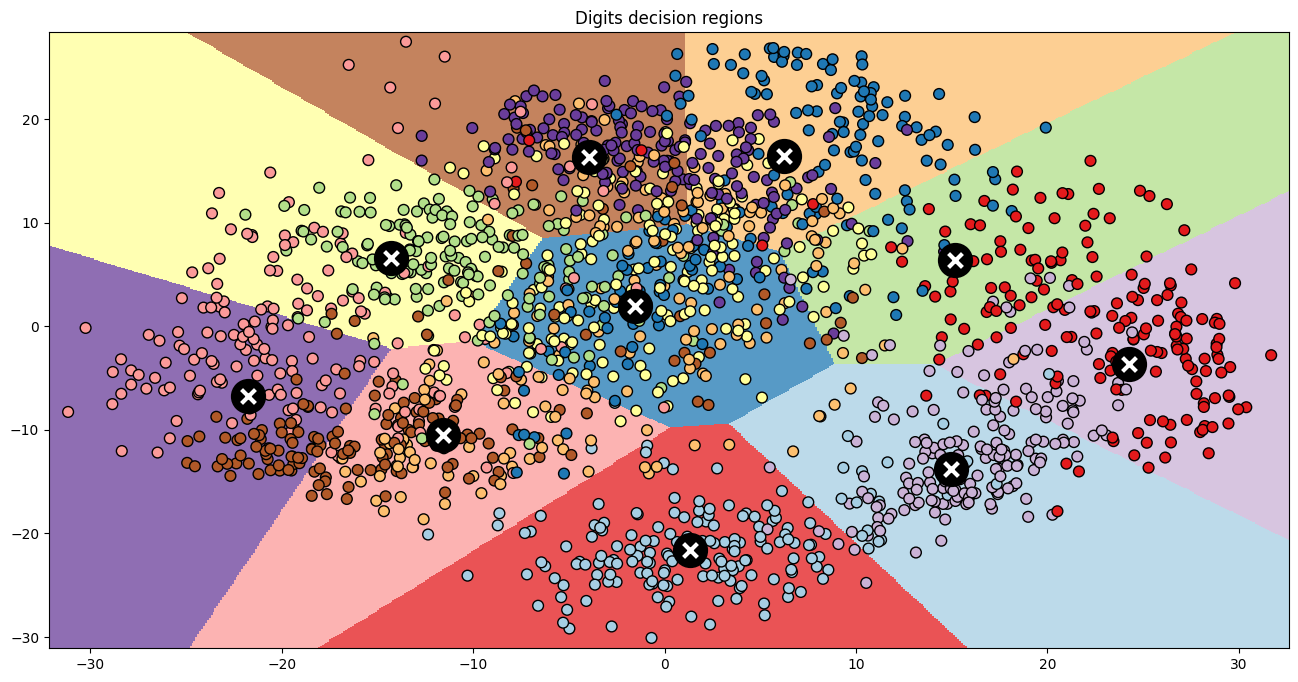

In [59]:
fig, ax = plt.subplots(figsize=(16,8))
plot_decision_regions(X_transformed, y, estimator, title="Digits decision regions", ax=ax)
ax.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    s=500,
    linewidths=3,
    facecolors='k', edgecolors='k', color='k'
)

ax.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="x",
    s=100,
    linewidths=3,
    color="w"
)